## Data Preparation
<details>
<summary><b> Binary Classification</b></summary>
In binary classification, we try to predict an output $y_i$ that can take **two possible values**:

$$
g(x_i) \approx y_i, \quad \text{where } y_i \in \{0, 1\}
$$

- $g(x_i)$: model’s prediction for the *i-th* sample  
- $y_i$: true label (target)

| Value | Meaning | Example |
|:------:|:---------|:---------|
| 0 | Negative class | Not Fail / No Churn / Not Spam |
| 1 | Positive class | Fail / Churn / Spam |

Each input $x_i$ represents features of one instance (e.g., one customer or one email).  
The goal is for the model to output a prediction $g(x_i)$ close to the true label $y_i$.  

</details>


In [26]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
df = pd.read_csv("predictive_maintenance_dataset.csv")
df[df['failure']==1].head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
4885,1/5/2015,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,56,1
6879,1/7/2015,S1F0CTDN,1,184069720,528,0,4,9,387871,32,32,3
8823,1/9/2015,W1F0PNA5,1,136429411,64784,0,406,30,224801,8,8,0
11957,1/13/2015,W1F13SRV,1,188251248,2040,0,0,6,39345,32,32,1
12668,1/14/2015,W1F1230J,1,220461296,0,0,0,14,325125,0,0,0


In [28]:
#quick checking the datatypes if it is okay
df.dtypes

date       object
device     object
failure     int64
metric1     int64
metric2     int64
metric3     int64
metric4     int64
metric5     int64
metric6     int64
metric7     int64
metric8     int64
metric9     int64
dtype: object

In [29]:
#Just a quick check on the whole data
df.describe().round()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.0,124494.0,124494.0,124494.0,124494.0,124494.0,124494.0,124494.0,124494.0,124494.0
mean,0.0,122388103.0,159.0,10.0,2.0,14.0,260173.0,0.0,0.0,13.0
std,0.0,70459334.0,2180.0,186.0,23.0,16.0,99151.0,7.0,7.0,276.0
min,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0
25%,0.0,61284762.0,0.0,0.0,0.0,8.0,221452.0,0.0,0.0,0.0
50%,0.0,122797388.0,0.0,0.0,0.0,10.0,249800.0,0.0,0.0,0.0
75%,0.0,183309640.0,0.0,0.0,0.0,12.0,310266.0,0.0,0.0,0.0
max,1.0,244140480.0,64968.0,24929.0,1666.0,98.0,689161.0,832.0,832.0,70000.0


## Setting up environment
 - Train 60% | Val 20% | Test 20%

<details>
    
    [image.png](attachment:c0356555-af73-4b9a-97a7-2ff6441a25b6.png)
    
</details>
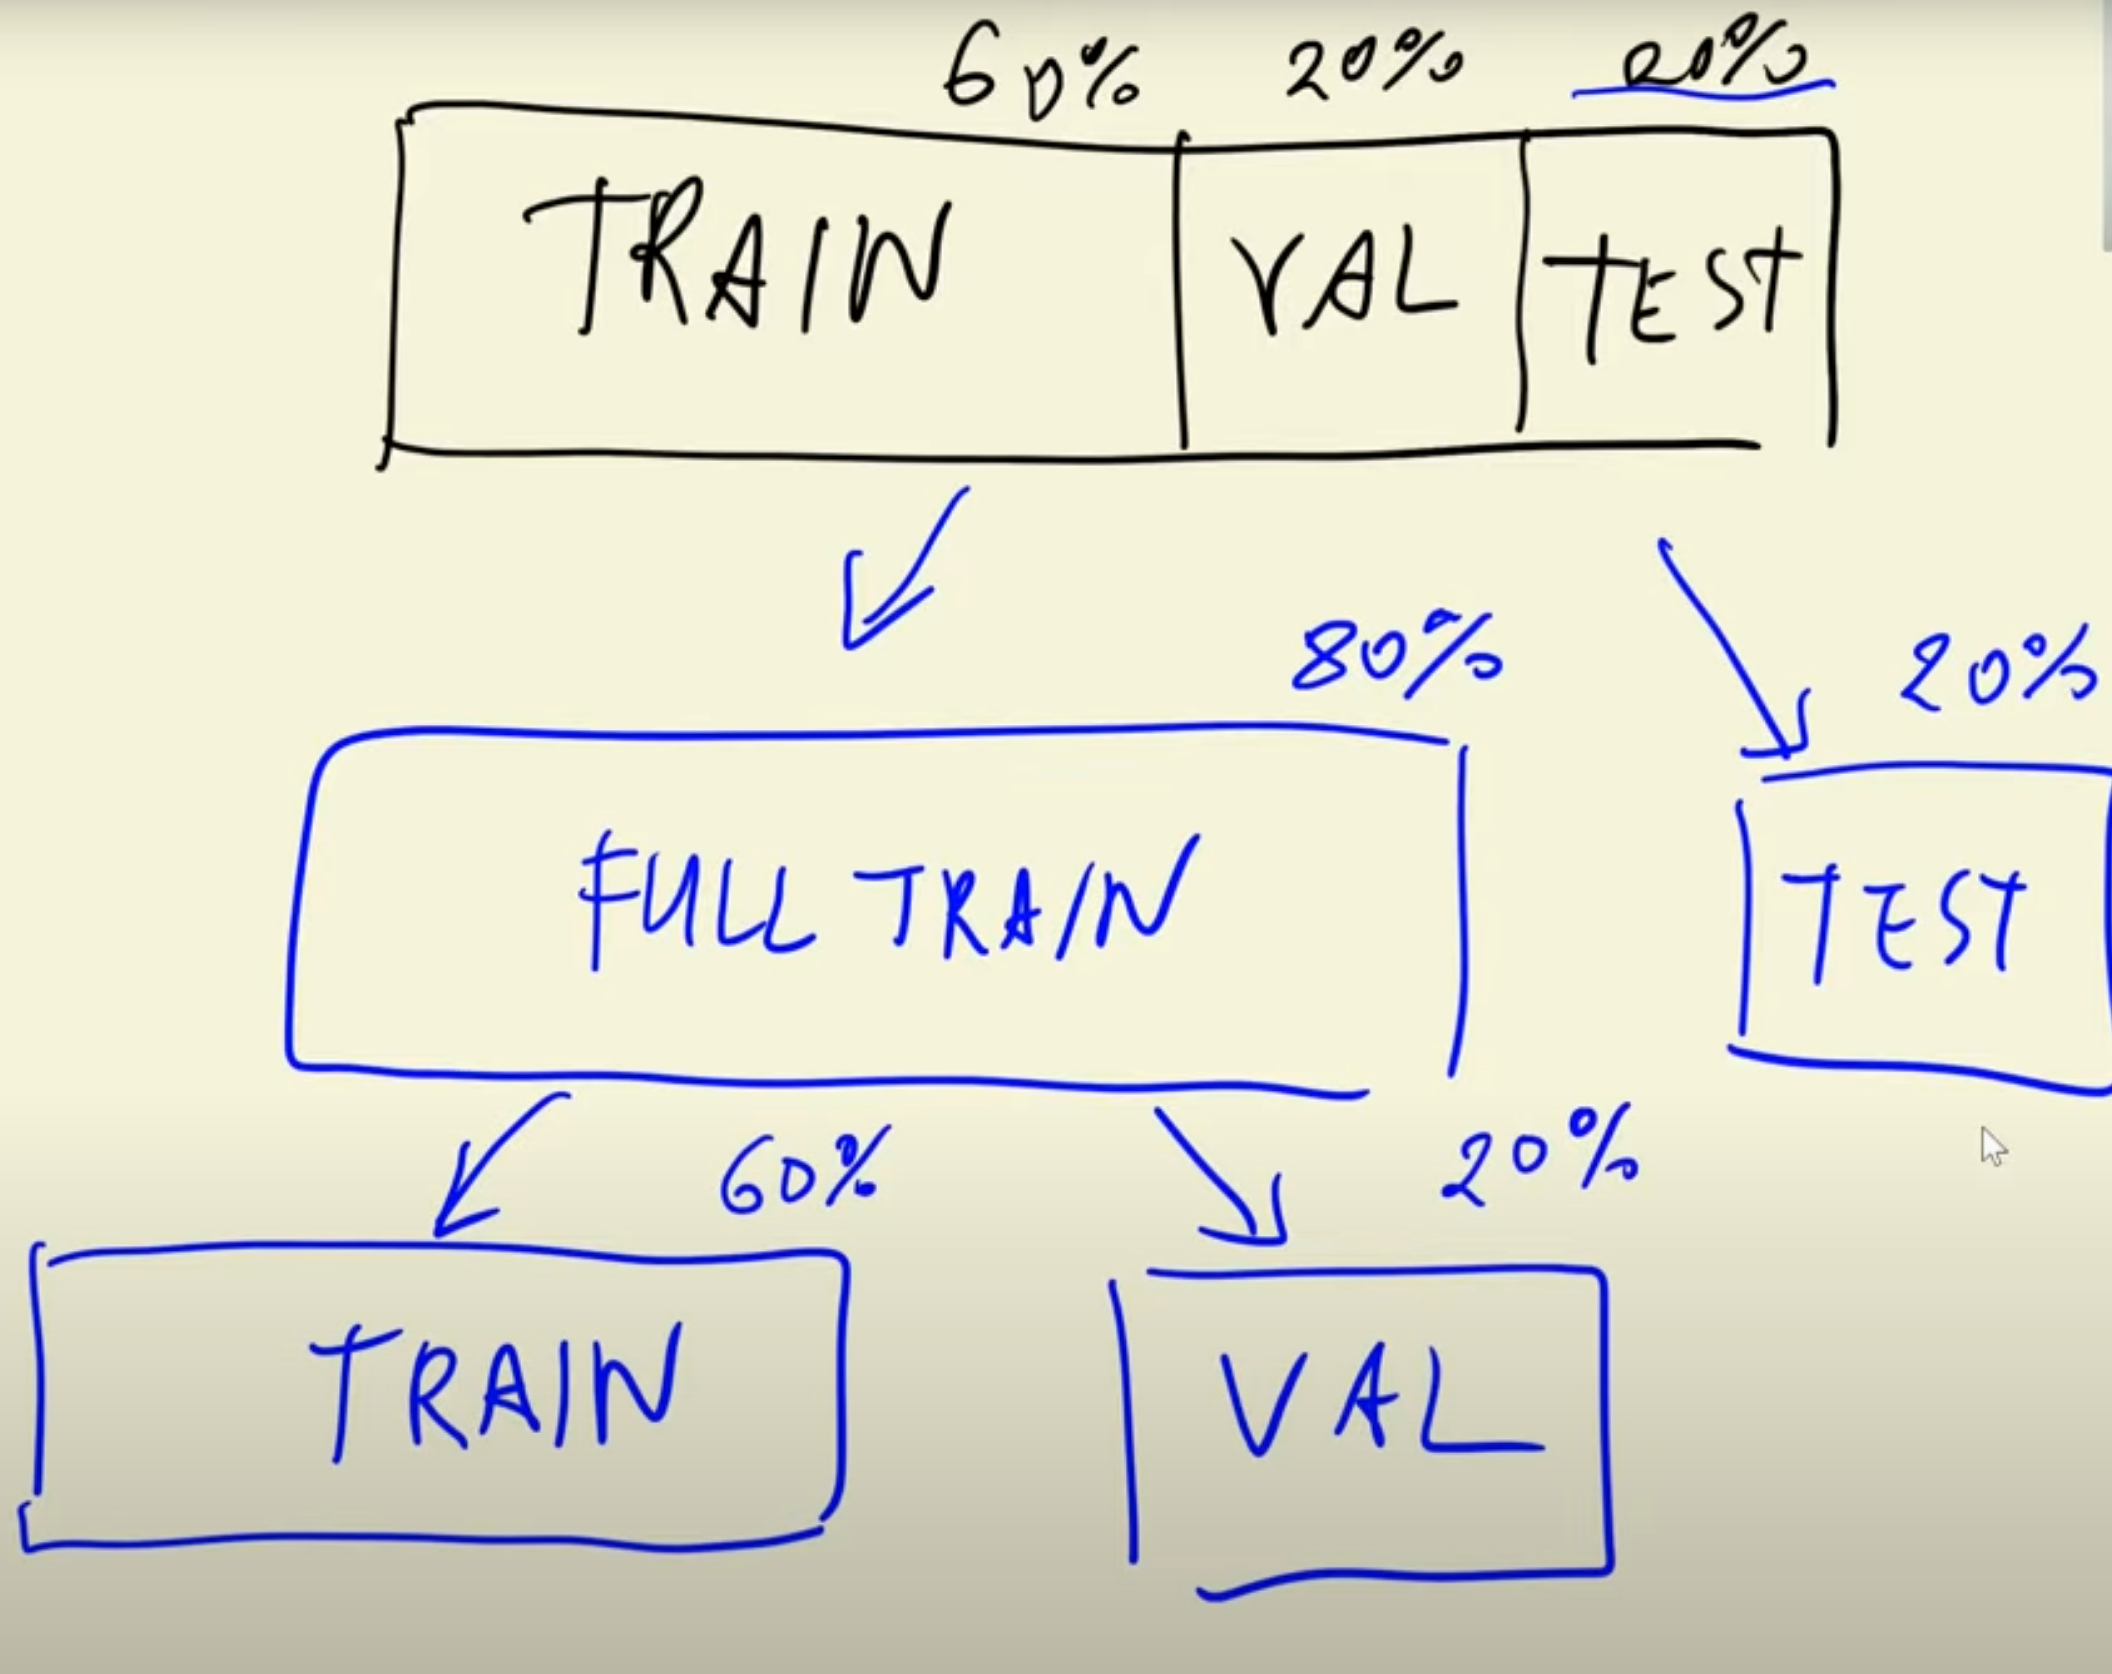

In [30]:
from sklearn.model_selection import train_test_split
#train_test_split?

In [31]:
# 80% data | 20% test data
df_full_train, df_test = train_test_split(df,test_size = 0.2, random_state=1)

In [32]:
len(df_full_train),len(df_test)

(99595, 24899)

In [33]:
# need to split our 80..20% of that data is not actual, we need to get 1/4
df_train, df_val = train_test_split(df_full_train,test_size = 0.25, random_state=1)

In [34]:
len(df_train), len(df_val),len(df_test)

(74696, 24899, 24899)

In [35]:
#reseting their index
for d in [df_train, df_val, df_test, df_full_train]:
    d.reset_index(drop=True, inplace=True)

In [36]:
#seperating target variables
y_train = df_train.failure.values
y_val  = df_val.failure.values
y_test = df_test.failure.values
y_full_train = df_full_train.failure.values

In [37]:
#deleting target variables from train data
del df_train['failure']
del df_val['failure']
del df_test['failure']

## EDA

In [38]:
#any missing value?
df_full_train.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [39]:
for d in [df_train, df_val, df_test, df_full_train]:
    # Convert 'date' from object to datetime
    d['date'] = pd.to_datetime(d['date'])
    
    # Extract components
    d['day'] = d['date'].dt.day
    d['month'] = d['date'].dt.month
    d['year'] = d['date'].dt.year

In [40]:
#lets see the distrubution
df_full_train.failure.value_counts(normalize = True)
## Failure rate aka the mean here

failure
0    0.999137
1    0.000863
Name: proportion, dtype: float64

In [41]:
global_failure = df_full_train.failure.mean()
global_failure = round(global_failure,5)

## Feature Importance

In [42]:
#Checking unique values 
df_full_train['device'].nunique()

1169

In [43]:
#checking Unique Values
df_full_train['device'].value_counts().head()

device
Z1F0KJDS    258
S1F0GGPP    255
W1F0G9T7    255
Z1F0KKN4    253
Z1F0GB8A    252
Name: count, dtype: int64

In [44]:
#Checking unique values 
df_full_train['month'].nunique()

11

We measure feature importance by comparing **global fail rate** and **group fail rate**.

$$
\text{Difference} = \text{Global fail Rate} - \text{Group fail Rate}
$$

- If **Difference > 0** → the **group is less likely to fail**  
- If **Difference < 0** → the **group is more likely to fail**

The **risk ratio** helps us understand how much more (or less) likely a certain group is to fail compared to the global fail rate.

$$
\text{Risk Ratio} = \frac{\text{Group fail Rate}}{\text{Global fail Rate}}
$$

- If **Risk Ratio > 1** → the group is **more likely to fail**  
- If **Risk Ratio < 1** → the group is **less likely to fail**

In [45]:
from IPython.display import display

In [46]:
# Lets check for all categorical values
categorical = ['device', 'month']
numerical = ['metric1','metric2','metric3','metric4','metric5','metric6','metric7','metric8','metric9']

for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).failure.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_failure
    df_group['risk'] = df_group['mean'] / global_failure
    
     # Filter rows where risk > 0
    df_filtered = df_group[df_group['risk'] > 0]
    df_sorted = df_filtered.sort_values(by='risk', ascending=False)    

    display(df_sorted)
    print()
    print()

device


,mean,count,diff,risk
device,,,,
S1F0RRB1,0.333333,3,0.332473,387.596899
S1F0CTDN,0.250000,4,0.249140,290.697674
S1F11MB0,0.166667,6,0.165807,193.798450
W1F0PNA5,0.125000,8,0.124140,145.348837
Z1F1AG5N,0.111111,9,0.110251,129.198966
...,...,...,...,...
S1F0GSHB,0.005682,176,0.004822,6.606765
Z1F0MRPJ,0.005208,192,0.004348,6.056202
S1F0JGJV,0.004525,221,0.003665,5.261496




month


,mean,count,diff,risk
month,,,,
5,0.002003,8988,0.001143,2.328686
7,0.001413,8492,0.000553,1.643133
10,0.001285,2334,0.000425,1.494590
1,0.000953,19939,0.000093,1.108031
4,0.000831,9630,-0.000029,0.965974
2,0.000639,15650,-0.000221,0.742997
6,0.000595,8403,-0.000265,0.691890
3,0.000503,15902,-0.000357,0.584978
8,0.000451,6647,-0.000409,0.524804


## Logistic Regression

In [47]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [48]:
#def sigmoid(z):
#    return 1 / (1 + np.exp(-z))

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [51]:
model.coef_[0].round(3)

array([-0.   , -0.   , -0.   , ...,  0.005,  0.   , -0.002], shape=(1173,))

In [52]:
##model.predict(X_train)
# Hard predictions

In [53]:
y_pred = model.predict_proba(X_val).round(2)[:,1]
# soft predictions(probability of failure
# prob of negative(non-Failure)  , prob of positive(failure)
y_pred

array([0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ], shape=(24899,))

In [54]:
failure_decision = (y_pred >= 0.45)

In [55]:
(y_val == failure_decision).mean()

np.float64(0.9982328607574601)

## Using Model

In [56]:
del df_full_train['failure']
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [57]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [58]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_full_train, y_full_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [59]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')

In [60]:
X_test = dv.transform(dicts_test)


In [61]:
y_pred = model.predict_proba(X_test)[:, 1]

In [62]:
churn_decision = (y_pred >= 0.45)

In [63]:
(churn_decision == y_test).mean()

np.float64(0.9989959436121932)

In [64]:
y_test

array([0, 0, 0, ..., 0, 0, 0], shape=(24899,))

In [65]:
metrics = dicts_test[-1]
metrics

{'device': 'W1F1CJ3G',
 'month': 9,
 'metric1': 56445512,
 'metric2': 0,
 'metric3': 7,
 'metric4': 0,
 'metric5': 8,
 'metric6': 272817,
 'metric7': 0,
 'metric8': 0,
 'metric9': 0}

In [66]:
X_small = dv.transform([metrics])

In [67]:
model.predict_proba(X_small)[0, 1]

np.float64(0.0006025294550097287)

In [68]:
y_test[-1]

np.int64(0)

In [69]:
##RMSE
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(y_test, y_pred)

0.030804618836164702

## KNN and Random Forest

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_full_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_full_train)

# Predict and evaluate
y_pred_knn = knn.predict(X_test_scaled)
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))


KNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24879
           1       0.00      0.00      0.00        20

    accuracy                           1.00     24899
   macro avg       0.50      0.50      0.50     24899
weighted avg       1.00      1.00      1.00     24899



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
